In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

In [5]:
batch_fname = BASEDIR / "inputs/short_answer/claude-3-5-sonnet-20241022/batch.jsonl"
fname = BASEDIR / "outputs/short_answer/claude-3-5-sonnet-20241022/outputs.jsonl"

batches = read_jsonl(batch_fname)
responses = read_jsonl(fname)
responses = [
    {
        "uid": resp["custom_id"].replace("-", "/"),
        "system": prompt["params"]["system"],
        "prompt": prompt["params"]["messages"],
        "response": ModelResponse.from_response(resp["result"]["message"], "anthropic", use_batch_api=True)
    }
    for prompt, resp in zip(batches, responses)
    if resp["custom_id"].replace("-", "/") in dataset_map
]
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
results_metadata = make_results_df(responses, answer_check_results, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results]) / len(dataset)

  0%|          | 0/4780 [00:00<?, ?it/s]

Function timed out after 10 seconds
(" Let's solve this step by step.\n\n1) For a logarithm to be defined, its argument must be positive.\n\n2) Working from the innermost logarithm outward:\n   * For $\\log_{2001}{x}$ to be defined: $x > 0$\n   * Let's call $\\log_{2001}{x} = a$\n\n3) For $\\log_{2002}(a)$ to be defined: $a > 0$\n   * This means $\\log_{2001}{x} > 0$\n   * Therefore, $x > 2001^1 = 2001$\n   * Let's call $\\log_{2002}(\\log_{2001}{x}) = b$\n\n4) For $\\log_{2003}(b)$ to be defined: $b > 0$\n   * This means $\\log_{2002}(\\log_{2001}{x}) > 0$\n   * Therefore, $\\log_{2001}{x} > 2002^1 = 2002$\n   * This means $x > 2001^{2002}$\n\n5) For $\\log_{2004}$ of the whole expression to be defined: \n   * $\\log_{2003}(\\log_{2002}(\\log_{2001}{x})) > 0$\n   * Therefore, $\\log_{2002}(\\log_{2001}{x}) > 2003^1 = 2003$\n   * This means $\\log_{2001}{x} > 2002^{2003}$\n   * Finally, $x > 2001^{2002^{2003}}$\n\n6) Therefore, $c = 2001^{2002^{2003}}$\n\nAnswer: $2001^{2002^{2003}}$",

0.4855648535564854

In [6]:
os.makedirs(BASEDIR / "results/claude-3-5-sonnet-20241022", exist_ok=True)
results_metadata.to_csv(BASEDIR / "results/claude-3-5-sonnet-20241022/results.csv")

In [7]:
results_metadata.value_counts("reason")

reason
stop    4780
Name: count, dtype: int64

## Cost

In [8]:
PRICES = get_pricing("claude-3-5-sonnet-20241022")

total_cost = 0
for row in results_metadata.itertuples():
    total_cost += PRICES["input_tokens"] * row.input_tokens
    total_cost += PRICES["output_tokens"] * row.output_tokens
total_cost / 2  # divide by 2 for Batch API

16.478636999999964

## Accuracy

In [9]:
accuracy_by_split(results_metadata, "level")

,count,accuracy
level,,
1,799,75.719650
2,1505,63.986711
3,1363,41.526045
4,719,21.835883
5,197,9.644670
6,197,5.583756


In [10]:
accuracy_by_split(results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,50.618557
counting_and_probability,812,44.950739
geometry,1268,36.198738
number_theory,601,44.425957
prealgebra,889,75.478065
precalculus,240,28.333333


## Output lengths

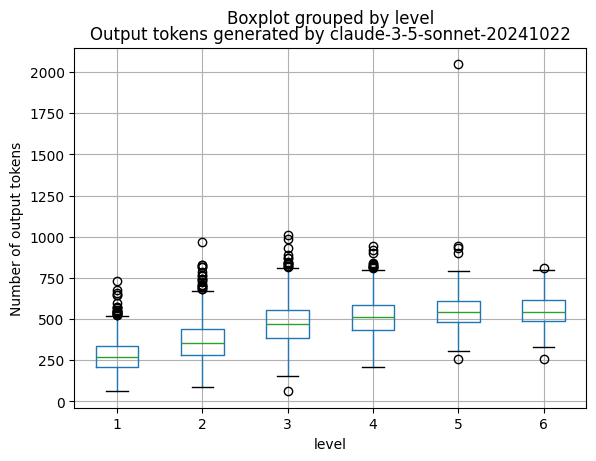

In [11]:
results_metadata.boxplot("output_tokens", "level")
plt.title("Output tokens generated by claude-3-5-sonnet-20241022")
plt.ylabel("Number of output tokens")
plt.show()

<Figure size 900x600 with 0 Axes>

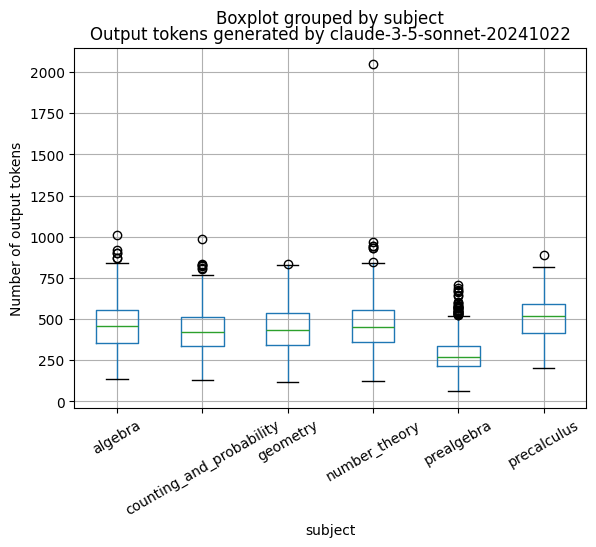

In [12]:
plt.figure(figsize=(9,6))
results_metadata.boxplot("output_tokens", "subject")
plt.title("Output tokens generated by claude-3-5-sonnet-20241022")
plt.ylabel("Number of output tokens")
plt.xticks(rotation=30)
plt.show()